<h1 style="color:blue; background:lightblue; line-height:1.5; text-align:center">* Quora Question Pair Similarity using Own Word Embedding and ML Models*</h1>

<h2 style="color:blue; background:pink; line-height:1.5">Import required libraries</h2>

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

<h2 style="color:blue; background:pink; line-height:1.5">Loading Dataset which has extracted features and Preprocessed</h2>

**Dataset link:** https://drive.google.com/file/d/1rxPJHAvSXzOPEpIqmaAsXvhJK8p4K4JN/view?usp=sharing

**Preprocessed Dataset link:** https://drive.google.com/file/d/1gKfuAAzJRs-l-0ftJgb-NQj8-PQrLqtn/view?usp=sharing

In [2]:
df=pd.read_csv('data/feat_extr_data.csv')
df.head()

,question1,question2,is_duplicate,que1_len,que2_len,que1_num_words,que2_num_words,total_words,common_words,shared_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,long_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,what minor would complement a computer science...,what is a good minor that will compliment a co...,1,52,66,8,12,19,8,0.42,...,0.499996,1.0,1.0,4.0,10.0,0.547170,81,85,81,83
1,how can i materialize an idea,what is the best way to materialize on an idea,1,29,46,6,10,16,2,0.12,...,0.299997,1.0,0.0,4.0,8.0,0.433333,64,72,53,79
2,what was the happiest day of your life and why...,what was is will be the happiest day of your life,1,53,49,12,11,22,11,0.50,...,0.666661,0.0,1.0,1.0,11.5,0.600000,75,78,84,88
3,what role project manager has in agile projects,what is the role of project management in agil...,1,47,68,8,11,19,8,0.42,...,0.454541,0.0,1.0,3.0,9.5,0.312500,64,70,59,71
4,who will win in america presidential elections...,between trump and clinton who will win us pres...,1,54,63,9,10,18,8,0.44,...,0.399996,0.0,0.0,1.0,9.5,0.400000,60,77,65,68


<h2 style="color:blue; background:pink; line-height:1.5">Dataset information</h2>

In [3]:
df.shape

(49998, 25)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49998 entries, 0 to 49997
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   question1           49998 non-null  object 
 1   question2           49998 non-null  object 
 2   is_duplicate        49998 non-null  int64  
 3   que1_len            49998 non-null  int64  
 4   que2_len            49998 non-null  int64  
 5   que1_num_words      49998 non-null  int64  
 6   que2_num_words      49998 non-null  int64  
 7   total_words         49998 non-null  int64  
 8   common_words        49998 non-null  int64  
 9   shared_words        49998 non-null  float64
 10  cwc_min             49998 non-null  float64
 11  cwc_max             49998 non-null  float64
 12  csc_min             49998 non-null  float64
 13  csc_max             49998 non-null  float64
 14  ctc_min             49998 non-null  float64
 15  ctc_max             49998 non-null  float64
 16  last

<h2 style="color:blue; background:pink; line-height:1.5">Missing values</h2>

In [5]:
df.isnull().sum()

question1             0
question2             0
is_duplicate          0
que1_len              0
que2_len              0
que1_num_words        0
que2_num_words        0
total_words           0
common_words          0
shared_words          0
cwc_min               0
cwc_max               0
csc_min               0
csc_max               0
ctc_min               0
ctc_max               0
last_word_eq          0
first_word_eq         0
abs_len_diff          0
mean_len              0
long_substr_ratio     0
fuzz_ratio            0
fuzz_partial_ratio    0
token_sort_ratio      0
token_set_ratio       0
dtype: int64

<h2 style="color:blue; background:pink; line-height:1.5">Data Balance check</h2>

In [6]:
class_balance=pd.DataFrame(df['is_duplicate'].value_counts()).reset_index()
class_balance.columns=["Class", "Count"]
class_balance['Percentage']=(class_balance['Count']/df.shape[0])*100
class_balance

,Class,Count,Percentage
0,1,25000,50.002
1,0,24998,49.998


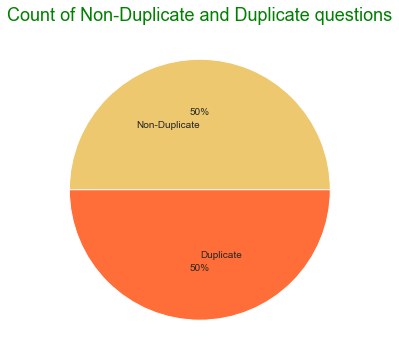

In [7]:
label=['Non-Duplicate', 'Duplicate'] 
color=sns.color_palette('rainbow')[4:6]
plt.figure(figsize=(6,6))
plt.pie(x=class_balance['Count'], labels=label, colors=color, autopct='%.0f%%' , labeldistance=0.5)
plt.title("Count of Non-Duplicate and Duplicate questions", fontsize=18, color='green');

<h2 style="color:blue; background:pink; line-height:1.5">Input and output feaures</h2>

In [8]:
X=df.drop('is_duplicate', axis=1)
y=df['is_duplicate']
print(X.shape, y.shape)

(49998, 24) (49998,)


<h2 style="color:blue; background:pink; line-height:1.5">Import necessary libraries for creating one hot representation and Embedding layer</h2>

In [9]:
import tensorflow as tf
tf.__version__

'2.11.0'

In [10]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Dense

<h2 style="color:blue; background:pink; line-height:1.5">Seperate Extracted features and apply word embedding to Question1 and Question2 Seperately and while splitting train test concatenate extracted features.</h2>

In [11]:
questions1=list(X['question1'])
questions2=list(X['question2'])
print(questions1[:2])
print(questions2[:2])

['what minor would complement a computer science major', 'how can i materialize an idea']
['what is a good minor that will compliment a computer science major', 'what is the best way to materialize on an idea']


In [12]:
extracted_features=['que1_len', 'que2_len',
       'que1_num_words', 'que2_num_words', 'total_words', 'common_words',
       'shared_words', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min',
       'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'long_substr_ratio', 'fuzz_ratio', 'fuzz_partial_ratio',
       'token_sort_ratio', 'token_set_ratio']

extracted_features=X[extracted_features]
extracted_features[:5]

,que1_len,que2_len,que1_num_words,que2_num_words,total_words,common_words,shared_words,cwc_min,cwc_max,csc_min,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,long_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,52,66,8,12,19,8,0.42,0.666656,0.666656,0.999950,...,0.499996,1.0,1.0,4.0,10.0,0.547170,81,85,81,83
1,29,46,6,10,16,2,0.12,0.999950,0.499988,0.249994,...,0.299997,1.0,0.0,4.0,8.0,0.433333,64,72,53,79
2,53,49,12,11,22,11,0.50,0.999967,0.999967,0.624992,...,0.666661,0.0,1.0,1.0,11.5,0.600000,75,78,84,88
3,47,68,8,11,19,8,0.42,0.599988,0.499992,0.666644,...,0.454541,0.0,1.0,3.0,9.5,0.312500,64,70,59,71
4,54,63,9,10,18,8,0.44,0.399992,0.333328,0.666644,...,0.399996,0.0,0.0,1.0,9.5,0.400000,60,77,65,68


<h2 style="color:blue; background:pink; line-height:1.5">Onehot Representation of corpus</h2>

In [13]:
voc_size=1000000
onehot_representation1=[one_hot(words,voc_size)for words in questions1]
onehot_representation2=[one_hot(words,voc_size)for words in questions2] 
print(onehot_representation1[:1])
print(onehot_representation2[:1])

[[786798, 847368, 851600, 742914, 536193, 74896, 760774, 453240]]
[[786798, 554008, 536193, 493213, 847368, 368225, 13684, 560368, 536193, 74896, 760774, 453240]]


In [14]:
print(questions1[1])
print(onehot_representation1[1])
print(questions2[1])
print(onehot_representation2[1])

how can i materialize an idea
[949749, 372004, 621832, 119357, 808650, 244068]
what is the best way to materialize on an idea
[786798, 554008, 117267, 397848, 908698, 571876, 119357, 636646, 808650, 244068]


In [15]:
tot_words_df1=pd.DataFrame(questions1)
tot_words_df1.columns=['sentences']
tot_words_df1['word_count']=tot_words_df1['sentences'].apply(lambda x: len(x.split(" ")))
print(tot_words_df1['word_count'].max())

tot_words_df2=pd.DataFrame(questions2)
tot_words_df2.columns=['sentences']
tot_words_df2['word_count']=tot_words_df2['sentences'].apply(lambda x: len(x.split(" ")))
print(tot_words_df2['word_count'].max())

83
128


**Maximum words in our document is 128 so select maxlen parameter as 130**

<h2 style="color:blue; background:pink; line-height:1.5">Word Embedding and padding</h2>

In [16]:
total_words_sentence=130
embedded_document1=pad_sequences(onehot_representation1, padding='post', maxlen=total_words_sentence)
embedded_document2=pad_sequences(onehot_representation2, padding='post', maxlen=total_words_sentence)
print(embedded_document1[:1])
print(embedded_document2[:1])

[[786798 847368 851600 742914 536193  74896 760774 453240      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0]]
[[786798 554008 536193 493213 847368 368225  13684 560368 5361

In [17]:
print(questions1[1])
print(onehot_representation1[1])
print(embedded_document1[1])
print("--"*30)
print(questions2[1])
print(onehot_representation2[1])
print(embedded_document2[1])

how can i materialize an idea
[949749, 372004, 621832, 119357, 808650, 244068]
[949749 372004 621832 119357 808650 244068      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      

<h2 style="color:blue; background:pink; line-height:1.5">Finalizing input and output features</h2>

In [18]:
extracted_features_array=np.array(extracted_features)
embedded_document_array=np.hstack((embedded_document1, embedded_document2))
X_final=np.hstack((extracted_features_array, embedded_document_array))
y_final=np.array(y)
print(X_final.shape, y_final.shape)

(49998, 282) (49998,)


<h2 style="color:blue; background:pink; line-height:1.5">Train test split</h2>

In [19]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)
print(x_train.shape, y_train.shape,x_test.shape,y_test.shape)

(39998, 282) (39998,) (10000, 282) (10000,)


<h2 style="color:blue; background:pink; line-height:1.5">Building model</h2>

#### Parameters:
- input_dim : Size of the vocabulary
- output_dim : Length of the vector for each word
- input_length : Maximum length of a sequence

<h2 style="color:blue; background:pink; line-height:1.5">Set Experiment<h2>

In [25]:
import mlflow
mlflow.set_experiment("Advance_approach_using_Word_Embedding")

2023/06/03 10:32:41 INFO mlflow.tracking.fluent: Experiment with name 'Advance_approach_using_Word_Embedding' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///D:/DATA%20SCIENCE%20Internship%20with%20Innomatics/Final_%20Project_Quora_Question_Pair_Similarity/mlruns/873137812390974611', creation_time=1685768561198, experiment_id='873137812390974611', last_update_time=1685768561198, lifecycle_stage='active', name='Advance_approach_using_Word_Embedding', tags={}>

<h2 style="color:blue; background:lightgreen; line-height:1">1. Logistic Regression<h2>

----------------------------------------------------------
Acuuracy=0.594
Precission=0.5762040557667935
Recall=0.7242134607726005
F1 Score=0.6417857773072173
----------------------------------------------------------
Confusion Matrix=



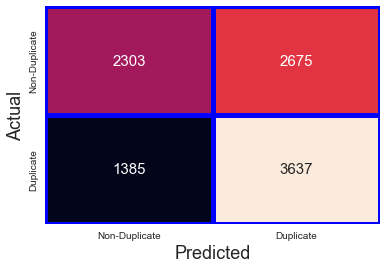

----------------------------------------------------------
Out of 10000 testing values 4060 are mis-classified.
----------------------------------------------------------
Classification Report=
               precision    recall  f1-score   support

           0       0.62      0.46      0.53      4978
           1       0.58      0.72      0.64      5022

    accuracy                           0.59     10000
   macro avg       0.60      0.59      0.59     10000
weighted avg       0.60      0.59      0.59     10000

----------------------------------------------------------


In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
import pickle
with mlflow.start_run():
    mlflow.set_tag("Owner","Suraj H")
    mlflow.set_tag("Algorithm", "Logistic")
    
    log_regression=LogisticRegression()
    log_regression.fit(x_train,y_train)
    #pickle.dump(log_regression, open("resources_simple_approach/logistic_regression.pkl","wb"))
    
    y_pred=log_regression.predict(x_test)
    acc=accuracy_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    
    print("----------------------------------------------------------")
    print("Acuuracy={}\nPrecission={}\nRecall={}\nF1 Score={}".format(acc, precision, recall, f1))
    print("----------------------------------------------------------")
    print("Confusion Matrix=\n")
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, annot_kws={"fontsize":15}, linewidths=5, linecolor='blue',
                yticklabels=["Non-Duplicate","Duplicate"], xticklabels=["Non-Duplicate","Duplicate"], cbar=None, fmt='g')
    plt.xlabel("Predicted",fontsize=18)
    plt.ylabel("Actual",fontsize=18)
    plt.savefig("resources_advance_approach_word_embedding/log_reg_conf_matrix.png")
    plt.show()
    print("----------------------------------------------------------")
    print("Out of {} testing values {} are mis-classified.".format(y_test.shape[0], sum(y_test!=y_pred)))
    print("----------------------------------------------------------")
    print("Classification Report=\n", classification_report(y_test,y_pred))
    print("----------------------------------------------------------")
    
    mlflow.log_metrics({"Accuracy":acc, "Precision":precision, "Recall":recall, "F1 Score":f1})
    mlflow.sklearn.log_model(log_regression, artifact_path="models")
    mlflow.log_artifact("resources_advance_approach_word_embedding/log_reg_conf_matrix.png")

<h2 style="color:blue; background:lightgreen; line-height:1">2. Naive Bayes<h2>

----------------------------------------------------------
Acuuracy=0.52
Precission=0.5113589848546869
Recall=0.9950219036240542
F1 Score=0.67554413951602
----------------------------------------------------------
Confusion Matrix=



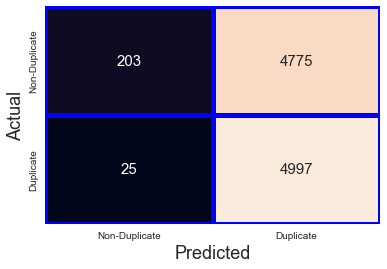

----------------------------------------------------------
Out of 10000 testing values 4800 are mis-classified.
----------------------------------------------------------
Classification Report=
               precision    recall  f1-score   support

           0       0.89      0.04      0.08      4978
           1       0.51      1.00      0.68      5022

    accuracy                           0.52     10000
   macro avg       0.70      0.52      0.38     10000
weighted avg       0.70      0.52      0.38     10000

----------------------------------------------------------


In [28]:
from sklearn.naive_bayes import GaussianNB
with mlflow.start_run():
    mlflow.set_tag("Owner","Suraj H")
    mlflow.set_tag("Algorithm", "Naive Bayes")
    
    naive_classifier=GaussianNB()
    naive_classifier.fit(x_train,y_train)
    #pickle.dump(naive_classifier, open("resources_special _cases/naive.pkl","wb"))
    
    y_pred=naive_classifier.predict(x_test)
    acc=accuracy_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    
    print("----------------------------------------------------------")
    print("Acuuracy={}\nPrecission={}\nRecall={}\nF1 Score={}".format(acc, precision, recall, f1))
    print("----------------------------------------------------------")
    print("Confusion Matrix=\n")
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, annot_kws={"fontsize":15}, linewidths=5, linecolor='blue',
                yticklabels=["Non-Duplicate","Duplicate"], xticklabels=["Non-Duplicate","Duplicate"], cbar=None, fmt='g')
    plt.xlabel("Predicted",fontsize=18)
    plt.ylabel("Actual",fontsize=18)
    plt.savefig("resources_advance_approach_word_embedding/naive_conf_matrix.png")
    plt.show()
    print("----------------------------------------------------------")
    print("Out of {} testing values {} are mis-classified.".format(y_test.shape[0], sum(y_test!=y_pred)))
    print("----------------------------------------------------------")
    print("Classification Report=\n", classification_report(y_test,y_pred))
    print("----------------------------------------------------------")
    
    mlflow.log_metrics({"Accuracy":acc, "Precision":precision, "Recall":recall, "F1 Score":f1})
    #mlflow.sklearn.log_model(naive_classifier, artifact_path="models")
    mlflow.log_artifact("resources_advance_approach_word_embedding/naive_conf_matrix.png")

<h2 style="color:blue; background:lightgreen; line-height:1">3. Decision Tree</h2>

----------------------------------------------------------
Acuuracy=0.6924
Precission=0.6960902861749295
Recall=0.6877737953006771
F1 Score=0.6919070512820513
----------------------------------------------------------
Confusion Matrix=



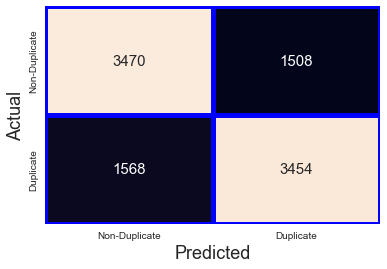

----------------------------------------------------------
Out of 10000 testing values 3076 are mis-classified.
----------------------------------------------------------
Classification Report=
               precision    recall  f1-score   support

           0       0.69      0.70      0.69      4978
           1       0.70      0.69      0.69      5022

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.69     10000
weighted avg       0.69      0.69      0.69     10000

----------------------------------------------------------


In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
import pickle
with mlflow.start_run():
    mlflow.set_tag("Owner","Suraj H")
    mlflow.set_tag("Algorithm", "Decision Tree")
    
    dt_classifier=DecisionTreeClassifier()
    dt_classifier.fit(x_train,y_train)
    #pickle.dump(dt_classifier, open("resources_advance_approach_with_TFIDF/decision_tree.pkl","wb"))
    
    y_pred=dt_classifier.predict(x_test)
    acc=accuracy_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    
    print("----------------------------------------------------------")
    print("Acuuracy={}\nPrecission={}\nRecall={}\nF1 Score={}".format(acc, precision, recall, f1))
    print("----------------------------------------------------------")
    print("Confusion Matrix=\n")
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, annot_kws={"fontsize":15}, linewidths=5, linecolor='blue',
                yticklabels=["Non-Duplicate","Duplicate"], xticklabels=["Non-Duplicate","Duplicate"], cbar=None, fmt='g')
    plt.xlabel("Predicted",fontsize=18)
    plt.ylabel("Actual",fontsize=18)
    plt.savefig("resources_advance_approach_word_embedding/decision_tree_conf_matrix.png")
    plt.show()
    print("----------------------------------------------------------")
    print("Out of {} testing values {} are mis-classified.".format(y_test.shape[0], sum(y_test!=y_pred)))
    print("----------------------------------------------------------")
    print("Classification Report=\n", classification_report(y_test,y_pred))
    print("----------------------------------------------------------")
    
    mlflow.log_metrics({"Accuracy":acc, "Precision":precision, "Recall":recall, "F1 Score":f1})
    mlflow.sklearn.log_model(dt_classifier, artifact_path="models")
    mlflow.log_artifact("resources_advance_approach_word_embedding/decision_tree_conf_matrix.png")

<h2 style="color:blue; background:lightgreen; line-height:1">4. Random Forest</h2>

----------------------------------------------------------
Acuuracy=0.7736
Precission=0.7303708653524892
Recall=0.8705694942254082
F1 Score=0.7943313953488372
----------------------------------------------------------
Confusion Matrix=



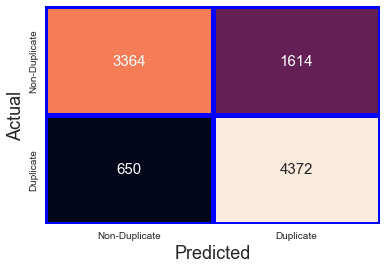

----------------------------------------------------------
Out of 10000 testing values 2264 are mis-classified.
----------------------------------------------------------
Classification Report=
               precision    recall  f1-score   support

           0       0.84      0.68      0.75      4978
           1       0.73      0.87      0.79      5022

    accuracy                           0.77     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.78      0.77      0.77     10000

----------------------------------------------------------


In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
import pickle
with mlflow.start_run():
    mlflow.set_tag("Owner","Suraj H")
    mlflow.set_tag("Algorithm", "Random Forest")
    
    rf_classifier=RandomForestClassifier()
    rf_classifier.fit(x_train,y_train)
    #pickle.dump(rf_classifier, open("resources_advance_approach_with_TFIDF/random_forest.pkl","wb"))
    
    y_pred=rf_classifier.predict(x_test)
    acc=accuracy_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    
    print("----------------------------------------------------------")
    print("Acuuracy={}\nPrecission={}\nRecall={}\nF1 Score={}".format(acc, precision, recall, f1))
    print("----------------------------------------------------------")
    print("Confusion Matrix=\n")
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, annot_kws={"fontsize":15}, linewidths=5, linecolor='blue',
                yticklabels=["Non-Duplicate","Duplicate"], xticklabels=["Non-Duplicate","Duplicate"], cbar=None, fmt='g')
    plt.xlabel("Predicted",fontsize=18)
    plt.ylabel("Actual",fontsize=18)
    plt.savefig("resources_advance_approach_word_embedding/random_forest_conf_matrix.png")
    plt.show()
    print("----------------------------------------------------------")
    print("Out of {} testing values {} are mis-classified.".format(y_test.shape[0], sum(y_test!=y_pred)))
    print("----------------------------------------------------------")
    print("Classification Report=\n", classification_report(y_test,y_pred))
    print("----------------------------------------------------------")
    
    mlflow.log_metrics({"Accuracy":acc, "Precision":precision, "Recall":recall, "F1 Score":f1})
    #mlflow.sklearn.log_model(rf_classifier, artifact_path="models")
    mlflow.log_artifact("resources_advance_approach_word_embedding/random_forest_conf_matrix.png")

<h2 style="color:blue; background:lightgreen; line-height:1">5. Gradient Boosting</h2>

----------------------------------------------------------
Acuuracy=0.7605
Precission=0.7062333176322814
Recall=0.8956590999601752
F1 Score=0.7897462909314372
----------------------------------------------------------
Confusion Matrix=



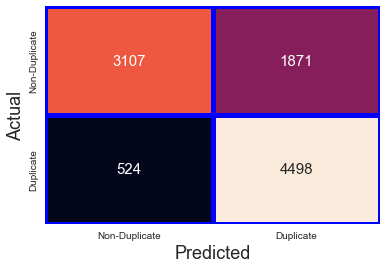

----------------------------------------------------------
Out of 10000 testing values 2395 are mis-classified.
----------------------------------------------------------
Classification Report=
               precision    recall  f1-score   support

           0       0.86      0.62      0.72      4978
           1       0.71      0.90      0.79      5022

    accuracy                           0.76     10000
   macro avg       0.78      0.76      0.76     10000
weighted avg       0.78      0.76      0.76     10000

----------------------------------------------------------


In [32]:
from sklearn.ensemble import GradientBoostingClassifier
with mlflow.start_run():
    mlflow.set_tag("Owner","Suraj H")
    mlflow.set_tag("Algorithm", "Gradient Boost")
    
    gb_classifier=GradientBoostingClassifier()
    gb_classifier.fit(x_train,y_train)
    #pickle.dump(gb_classifier, open("resources_advance_approach_with_TFIDF/gradient_boostig.pkl","wb"))
    
    y_pred=gb_classifier.predict(x_test)
    acc=accuracy_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    
    print("----------------------------------------------------------")
    print("Acuuracy={}\nPrecission={}\nRecall={}\nF1 Score={}".format(acc, precision, recall, f1))
    print("----------------------------------------------------------")
    print("Confusion Matrix=\n")
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, annot_kws={"fontsize":15}, linewidths=5, linecolor='blue',
                yticklabels=["Non-Duplicate","Duplicate"], xticklabels=["Non-Duplicate","Duplicate"], cbar=None, fmt='g')
    plt.xlabel("Predicted",fontsize=18)
    plt.ylabel("Actual",fontsize=18)
    plt.savefig("resources_advance_approach_word_embedding/gradient_boost_conf_matrix.png")
    plt.show()
    print("----------------------------------------------------------")
    print("Out of {} testing values {} are mis-classified.".format(y_test.shape[0], sum(y_test!=y_pred)))
    print("----------------------------------------------------------")
    print("Classification Report=\n", classification_report(y_test,y_pred))
    print("----------------------------------------------------------")
    
    mlflow.log_metrics({"Accuracy":acc, "Precision":precision, "Recall":recall, "F1 Score":f1})
    #mlflow.sklearn.log_model(gb_classifier, artifact_path="models")
    mlflow.log_artifact("resources_advance_approach_word_embedding/gradient_boost_conf_matrix.png")

<h2 style="color:blue; background:lightgreen; line-height:1">6. Ada Boost</h2>

----------------------------------------------------------
Acuuracy=0.7411
Precission=0.6968128134606051
Recall=0.857626443647949
F1 Score=0.7689011871820048
----------------------------------------------------------
Confusion Matrix=



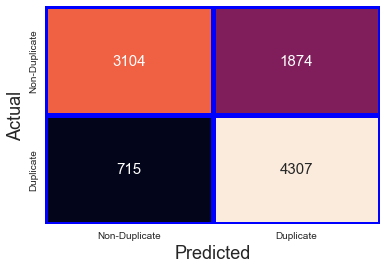

----------------------------------------------------------
Out of 10000 testing values 2589 are mis-classified.
----------------------------------------------------------
Classification Report=
               precision    recall  f1-score   support

           0       0.81      0.62      0.71      4978
           1       0.70      0.86      0.77      5022

    accuracy                           0.74     10000
   macro avg       0.75      0.74      0.74     10000
weighted avg       0.75      0.74      0.74     10000

----------------------------------------------------------


In [33]:
from sklearn.ensemble import AdaBoostClassifier
with mlflow.start_run():
    mlflow.set_tag("Owner","Suraj H")
    mlflow.set_tag("Algorithm", "Ada Boost")
    
    ada_classifier=AdaBoostClassifier()
    ada_classifier.fit(x_train,y_train)
    #pickle.dump(ada_classifier, open("resources_advance_approach_with_TFIDF/ada_boosting.pkl","wb"))
    
    y_pred=ada_classifier.predict(x_test)
    acc=accuracy_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    
    print("----------------------------------------------------------")
    print("Acuuracy={}\nPrecission={}\nRecall={}\nF1 Score={}".format(acc, precision, recall, f1))
    print("----------------------------------------------------------")
    print("Confusion Matrix=\n")
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, annot_kws={"fontsize":15}, linewidths=5, linecolor='blue',
                yticklabels=["Non-Duplicate","Duplicate"], xticklabels=["Non-Duplicate","Duplicate"], cbar=None, fmt='g')
    plt.xlabel("Predicted",fontsize=18)
    plt.ylabel("Actual",fontsize=18)
    plt.savefig("resources_advance_approach_word_embedding/ada_boost_conf_matrix.png")
    plt.show()
    print("----------------------------------------------------------")
    print("Out of {} testing values {} are mis-classified.".format(y_test.shape[0], sum(y_test!=y_pred)))
    print("----------------------------------------------------------")
    print("Classification Report=\n", classification_report(y_test,y_pred))
    print("----------------------------------------------------------")
    
    mlflow.log_metrics({"Accuracy":acc, "Precision":precision, "Recall":recall, "F1 Score":f1})
    mlflow.sklearn.log_model(ada_classifier, artifact_path="models")
    mlflow.log_artifact("resources_advance_approach_word_embedding/ada_boost_conf_matrix.png")

<h2 style="color:blue; background:lightgreen; line-height:1">7. XG Boost</h2>

----------------------------------------------------------
Acuuracy=0.7795
Precission=0.7452550931568866
Recall=0.8522500995619275
F1 Score=0.7951695308871342
----------------------------------------------------------
Confusion Matrix=



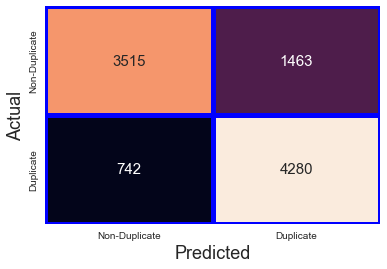

----------------------------------------------------------
Out of 10000 testing values 2205 are mis-classified.
----------------------------------------------------------
Classification Report=
               precision    recall  f1-score   support

           0       0.83      0.71      0.76      4978
           1       0.75      0.85      0.80      5022

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.78      0.78     10000

----------------------------------------------------------


In [31]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
import pickle
with mlflow.start_run():
    mlflow.set_tag("Owner","Suraj H")
    mlflow.set_tag("Algorithm", "XG Boost")
    
    xgb_classifier=XGBClassifier()
    xgb_classifier.fit(x_train,y_train)
    #pickle.dump(xgb_classifier, open("resources_simple_approach/xgboost.pkl","wb"))
    
    y_pred=xgb_classifier.predict(x_test)
    acc=accuracy_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    
    print("----------------------------------------------------------")
    print("Acuuracy={}\nPrecission={}\nRecall={}\nF1 Score={}".format(acc, precision, recall, f1))
    print("----------------------------------------------------------")
    print("Confusion Matrix=\n")
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, annot_kws={"fontsize":15}, linewidths=5, linecolor='blue',
                yticklabels=["Non-Duplicate","Duplicate"], xticklabels=["Non-Duplicate","Duplicate"], cbar=None, fmt='g')
    plt.xlabel("Predicted",fontsize=18)
    plt.ylabel("Actual",fontsize=18)
    plt.savefig("resources_advance_approach_word_embedding/xgboost_conf_matrix.png")
    plt.show()
    print("----------------------------------------------------------")
    print("Out of {} testing values {} are mis-classified.".format(y_test.shape[0], sum(y_test!=y_pred)))
    print("----------------------------------------------------------")
    print("Classification Report=\n", classification_report(y_test,y_pred))
    print("----------------------------------------------------------")
    
    mlflow.log_metrics({"Accuracy":acc, "Precision":precision, "Recall":recall, "F1 Score":f1})
    #mlflow.sklearn.log_model(xgb_classifier, artifact_path="models")
    mlflow.log_artifact("resources_advance_approach_word_embedding/xgboost_conf_matrix.png")

### Inference:
 **Accuracy of XG Boost model is high(78%).**